<a href="https://colab.research.google.com/github/Createdd/computervision_ue/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

available on 

## https://colab.research.google.com/drive/1UXrw17Lsbt-hsOIerbMG4JuFzpn73DWK

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/cv_data/

/content/drive/MyDrive/cv_data


In [4]:
!apt install unzip
# !unzip ./data_WiSAR.zip -d .

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [5]:
%ls

data/  data_WiSAR.zip  integrated/


In [6]:
import torchvision
import torch
import torch.nn as nn

import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta

# https://afagarap.github.io/2020/01/26/implementing-autoencoder-in-pytorch.html
# https://benjoe.medium.com/anomaly-detection-using-pytorch-autoencoder-and-mnist-31c5c2186329
# https://medium.com/analytics-vidhya/anomaly-detection-in-images-autoencoders-b780abf88f51

## Load data


In [7]:
from torchvision import datasets, transforms

data_dir = './data'
# DATA_DIR = 'data/train/train-1-0/0-B01.png'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)

# train_transforms = transforms.Compose([
#                                         transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
#                                        transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.5, 0.5, 0.5], 
#                                                            [0.5, 0.5, 0.5])])
train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                       transforms.Resize(28), #225
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                       #transforms.Normalize([0.5, 0.5, 0.5], 
                                        #                   [0.5, 0.5, 0.5])
                                      transforms.Normalize([0.5], 
                                                           [0.5])])

train_data = datasets.ImageFolder(data_dir + '/train', 
                                  transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', 
                                 transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', 
                                  transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           shuffle=True,
                                          batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, 
                                         batch_size=32)
validation_loader = torch.utils.data.DataLoader(validation_data, 
                                         batch_size=32)

In [8]:
train_data

Dataset ImageFolder
    Number of datapoints: 1820
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [9]:
def imshow(img):
    plt.figure(figsize=(10,8))
    plt.imshow(img.permute(1,2,0))




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


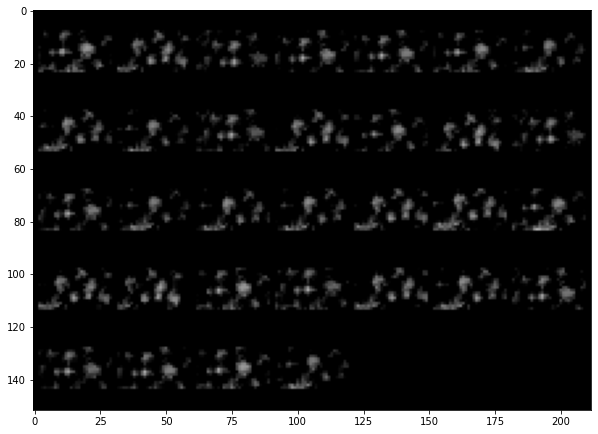

In [10]:
image, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(image,nrow=7))


## Build architecture

In [21]:
# import tensorflow as tf

# # Create the Encoder and Decoder
# #pass the gray scale input image of size(28,28,1)
# inputs = tf.keras.Input(shape=(28, 28, 1), name='input_layer')
# # Conv Block 1 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# # Conv Block 2 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# # Conv Block 3 -> BatchNorm->leaky Relu
# encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
# encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
# encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
# #Decoder
# # DeConv Block 1-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# # DeConv Block 2-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# # DeConv Block 3-> BatchNorm->leaky Relu
# decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
# decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
# decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# # output
# outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [27]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.models import Model

input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248

In [29]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator()
# train_it = datagen.flow_from_directory('data/train/', class_mode='binary', batch_size=64)

Found 1820 images belonging to 26 classes.


In [36]:
from keras.preprocessing.image import ImageDataGenerator

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

train_datagen = ImageDataGenerator(rescale=1 / 255)
train_generator = train_datagen.flow_from_directory(
    'data/train/', 
    target_size=(28,28), 
    #image_size=(28,28),
    color_mode='grayscale', 
    class_mode='input', 
    batch_size=128)#256)

test_generator = train_datagen.flow_from_directory(
    'data/test/', 
    target_size=(28,28), 
    #image_size=(28,28),
    color_mode='grayscale', 
    class_mode='input', 
    batch_size=128)

Found 1820 images belonging to 26 classes.
Found 910 images belonging to 13 classes.


In [33]:
hist=autoencoder.fit(
                train_generator,
                epochs=1,
                #batch_size=128,
                #shuffle=True,
                #validation_data=(train_it)
                )


8/8 [==============================] - 220s 26s/step - loss: 0.6813


In [ ]:
predictions = autoencoder.predict(test_generator)
display(test_generator, predictions)

In [39]:
new, _ = next(test_generator)
new

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

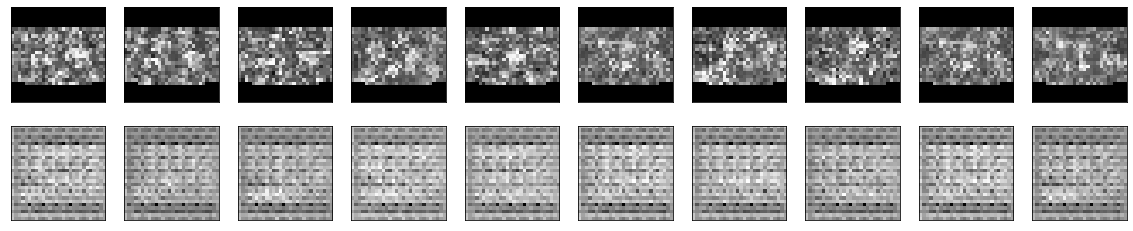

In [40]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

new, _ = next(test_generator)
display(new, predictions)

In [14]:
# from PIL import Image
# #img_data = np.random.random(size=(100, 100, 3))
# img = tf.keras.preprocessing.image.array_to_img(train_data)
# array = tf.keras.preprocessing.image.img_to_array(img)

# def preprocess(array):
#     """
#     Normalizes the supplied array and reshapes it into the appropriate format.
#     """

#     array = array.astype("float32") / 255.0
#     array = np.reshape(array, (len(array), 28, 28, 1))
#     return array

# new = preprocess(train_data)

KeyboardInterrupt: ignored

In [ ]:
# batchX, batchy = train_it.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

# x_train = train_data.astype('float32') / 255.
# x_test = test_data.astype('float32') / 255.
# x_train = np.reshape(train_data, (len(train_data), 28, 28, 1))
# x_test = np.reshape(test_data, (len(test_data), 28, 28, 1))

In [ ]:
from torch.autograd import Variable
import pylab

for epoch in range(num_epochs):
    i = 0
    for img,_ in train_loader:
        # print("now")

        x = img.view(img.size(0), -1)

        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)

        xhat = model(x)

        loss = mse_loss(xhat, x)
        losses[epoch] = losses[epoch] * (i / (i + 1.)) + loss * (1. / (i + 1.))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1

    plt.figure()
    pylab.xlim(0, num_epochs)
    plt.plot(range(0, num_epochs), losses, label='loss')
    plt.legend()
    plt.savefig(os.path.join(mount_dir+"/save/", 'loss.pdf'))
    plt.close()

    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss))


In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [ ]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
!tensorboard --logdir=/tmp/autoencoder


In [ ]:
trainloader

In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(trainloader,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(testloader),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])